<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Tri_vector_emergence_from_a_single_axis_(Phi)_instability_AJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

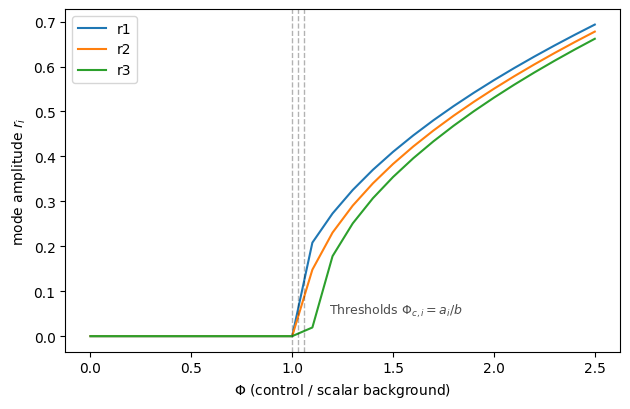

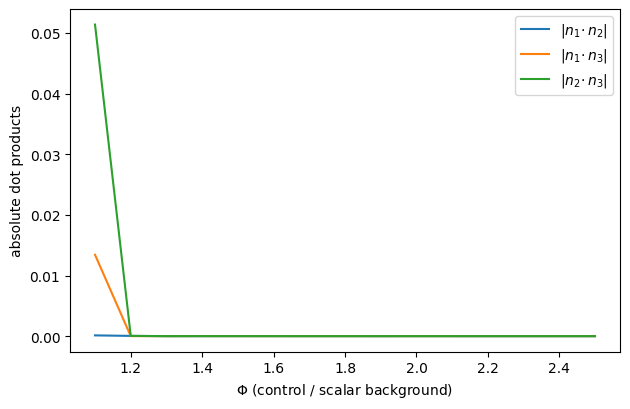

Φ≈0.90  r=[0. 0. 0.]   |dots|=[nan, nan, nan]   F=0.000000
Φ≈1.20  r=[0.273  0.2305 0.178 ]   |dots|=[3.999848388139965e-05, 3.5670616961303026e-06, 4.405489635206372e-05]   F=-0.014190
Φ≈2.00  r=[0.5697 0.5506 0.5308]   |dots|=[1.4765651307202532e-06, 1.2055474550853873e-06, 1.289804448856291e-06]   F=-0.441690
Saved snapshot -> appendix_AJ_results.json
Done.


In [1]:
# === Tri-vector emergence from a single-axis (Φ) instability ===
# Appendix AJ: Sequential or symmetric thresholds; masked dot-products; annotated Φ_c; PNG/PDF export

import json, sys, platform
import numpy as np
from numpy.random import default_rng
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ----------------------- Configuration ---------------------------------------
SEQUENTIAL = True      # True => a1 < a2 < a3 (cascade); False => all equal (symmetric onset)
RNG_SEED   = 42        # deterministic runs
N_STARTS   = 32        # multi-starts per Φ
MAXITER    = 2000      # optimizer iterations
PHI_MIN, PHI_MAX, PHI_STEPS = 0.0, 2.5, 26  # Φ sweep
SAVE_FIGS  = True      # export figures
SAVE_JSON  = True      # export snapshot with results & environment
MASK_EPS   = 1e-6      # mask |n_i·n_j| until both r_i, r_j > MASK_EPS
FIG_BASE   = "appendix_AJ"  # file stem for outputs

# ------------------------ Model Parameters ------------------------------------
# Free energy: F = Σ_i (a_i - b Φ) r_i^2 + c Σ_i r_i^4
#              + d Σ_{i<j} r_i^2 r_j^2
#              + e Σ_{i<j} (n_i·n_j)^2 r_i^2 r_j^2
# Directions n_i are softly unit-enforced via λ Σ_i (||n_i||^2 - 1)^2
if SEQUENTIAL:
    a_vec = np.array([1.00, 1.03, 1.06])   # cascade thresholds: r1 → r2 → r3
else:
    a_vec = np.array([1.00, 1.00, 1.00])   # simultaneous onset
b   = 1.0   # coupling to Φ (instability when b*Φ > a_i)
c   = 1.0   # quartic self
d   = 0.6   # quartic cross-amplitude (prevents single-mode monopoly)
e   = 2.0   # orthogonality penalty (>0 → n_i ⟂ n_j when multiple modes)
lam = 50.0  # soft unit-norm penalty for directions

# ------------------------ Helpers & Energy ------------------------------------
rng = default_rng(RNG_SEED)

def split_vars(x: np.ndarray):
    """Unpack optimization vector into amplitudes r and directions n1,n2,n3."""
    r  = x[0:3]                # we enforce r >= 0 via bounds in the optimizer
    n1 = x[3:6]; n2 = x[6:9]; n3 = x[9:12]
    return r, (n1, n2, n3)

def energy(x: np.ndarray, Phi: float) -> float:
    """Landau free energy with orthogonality enforcement when multiple modes are nonzero."""
    r, (n1, n2, n3) = split_vars(x)

    # soft unit-norm constraints for directions
    unit_pen = lam * ((np.dot(n1,n1)-1.0)**2 + (np.dot(n2,n2)-1.0)**2 + (np.dot(n3,n3)-1.0)**2)

    # scalar-driven quadratic + quartics
    quad   = np.sum((a_vec - b*Phi) * r**2)
    self4  = c * np.sum(r**4)
    cross4 = d * (r[0]**2*r[1]**2 + r[0]**2*r[2]**2 + r[1]**2*r[2]**2)

    # orthogonality penalty (naturally switches on only when r_i,r_j > 0)
    dotsq_12 = (np.dot(n1, n2))**2
    dotsq_13 = (np.dot(n1, n3))**2
    dotsq_23 = (np.dot(n2, n3))**2
    ortho    = e * (dotsq_12*r[0]**2*r[1]**2 +
                    dotsq_13*r[0]**2*r[2]**2 +
                    dotsq_23*r[1]**2*r[2]**2)

    return float(quad + self4 + cross4 + ortho + unit_pen)

# Bounds: r_i >= 0, directions unbounded (unit-penalty keeps them ~unit length)
_BOUNDS = [(0.0, None), (0.0, None), (0.0, None)] + [(None, None)]*9

def random_start() -> np.ndarray:
    """Random initial state for multi-start globalization."""
    r0 = rng.random(3)               # in [0,1)
    n0 = rng.normal(size=(3,3))      # random directions (soft-normalized by penalty)
    return np.concatenate([r0, n0.reshape(-1)])

def minimize_for_phi(Phi: float, n_starts: int = N_STARTS, maxiter: int = MAXITER):
    """Multi-start L-BFGS-B to find a low-energy minimum at a given Φ."""
    best_val = np.inf
    best_x   = None
    for _ in range(n_starts):
        x0  = random_start()
        res = minimize(energy, x0, args=(Phi,),
                       method="L-BFGS-B",
                       bounds=_BOUNDS,
                       options=dict(maxiter=maxiter, ftol=1e-12))
        if res.fun < best_val:
            best_val = float(res.fun)
            best_x   = res.x.astype(float, copy=True)
    if best_x is None:
        raise RuntimeError("No minimum found — consider increasing N_STARTS or MAXITER.")
    return best_x, best_val

# ------------------------- Sweep Φ and collect solutions ----------------------
Phi_vals = np.linspace(PHI_MIN, PHI_MAX, PHI_STEPS)
solutions = []

for Phi in Phi_vals:
    x_star, f_star = minimize_for_phi(Phi)
    r, (n1, n2, n3) = split_vars(x_star)

    # Normalize directions for reporting (the λ-penalty already keeps them near unit)
    def _safe_unit(v):
        nrm = np.linalg.norm(v)
        return v / (nrm + 1e-12)
    n1 = _safe_unit(n1); n2 = _safe_unit(n2); n3 = _safe_unit(n3)

    # Mask dot-products until both amplitudes in a pair are > MASK_EPS
    pairs = [(0,1), (0,2), (1,2)]
    vecs  = (n1, n2, n3)
    dots  = []
    for (i,j) in pairs:
        if (r[i] > MASK_EPS) and (r[j] > MASK_EPS):
            dots.append(abs(float(np.dot(vecs[i], vecs[j]))))
        else:
            dots.append(np.nan)

    solutions.append(dict(Phi=float(Phi),
                          r=r.astype(float),
                          n=(n1.astype(float), n2.astype(float), n3.astype(float)),
                          dots=dots, F=float(f_star)))

# ------------------------------- Plots ----------------------------------------
# Plot 1: amplitudes with annotated thresholds Φ_c,i = a_i / b
plt.figure(figsize=(6.4, 4.2))
plt.plot(Phi_vals, [s["r"][0] for s in solutions], label="r1")
plt.plot(Phi_vals, [s["r"][1] for s in solutions], label="r2")
plt.plot(Phi_vals, [s["r"][2] for s in solutions], label="r3")
plt.xlabel(r"$\Phi$ (control / scalar background)")
plt.ylabel(r"mode amplitude $r_i$")
plt.legend()

phi_c = a_vec / b
for v in phi_c:
    plt.axvline(v, color='k', linestyle='--', alpha=0.3, linewidth=1)
plt.text(float(phi_c.mean())+0.15, 0.05, r"Thresholds $\Phi_{c,i}=a_i/b$", fontsize=9, alpha=0.7)

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f"{FIG_BASE}_amplitudes_vs_phi.png", dpi=300)
    plt.savefig(f"{FIG_BASE}_amplitudes_vs_phi.pdf")
plt.show()

# Plot 2: absolute dot-products (masked pre-condensation)
plt.figure(figsize=(6.4, 4.2))
labels = [r"$|n_1\!\cdot n_2|$", r"$|n_1\!\cdot n_3|$", r"$|n_2\!\cdot n_3|$"]
for j in range(3):
    plt.plot(Phi_vals, [s["dots"][j] for s in solutions], label=labels[j])
plt.xlabel(r"$\Phi$ (control / scalar background)")
plt.ylabel(r"absolute dot products")
plt.legend()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f"{FIG_BASE}_dotproducts_vs_phi.png", dpi=300)
    plt.savefig(f"{FIG_BASE}_dotproducts_vs_phi.pdf")
plt.show()

# -------------------------- Representative outputs ----------------------------
def nearest_solution(phi_target: float):
    return min(solutions, key=lambda S: abs(S["Phi"] - float(phi_target)))

for phi_target in [0.9, 1.2, 2.0]:
    s = nearest_solution(phi_target)
    r = np.array(s["r"])
    print(f"Φ≈{s['Phi']:.2f}  r={np.array2string(r, precision=4)}   |dots|={s['dots']}   F={s['F']:.6f}")

# -------------------------- Snapshot (provenance) -----------------------------
if SAVE_JSON:
    snapshot = {
        "appendix": "AJ",
        "sequential": bool(SEQUENTIAL),
        "rng_seed": int(RNG_SEED),
        "n_starts": int(N_STARTS),
        "maxiter": int(MAXITER),
        "phi_grid": {"min": float(PHI_MIN), "max": float(PHI_MAX), "steps": int(PHI_STEPS)},
        "params": {
            "a_vec": a_vec.astype(float).tolist(),
            "b": float(b), "c": float(c), "d": float(d), "e": float(e), "lambda": float(lam)
        },
        "phi_thresholds": (a_vec / b).astype(float).tolist(),
        "solutions": [
            {"Phi": s["Phi"], "r": np.array(s["r"]).tolist(), "dots": list(map(lambda x: None if np.isnan(x) else float(x), s["dots"])), "F": s["F"]}
            for s in solutions
        ],
        "environment": {
            "python": sys.version.split()[0],
            "numpy": np.__version__,
            "scipy": __import__("scipy").__version__,
            "matplotlib": __import__("matplotlib").__version__,
            "platform": platform.platform()
        }
    }
    json_name = f"{FIG_BASE}_results.json"
    with open(json_name, "w", encoding="utf-8") as f:
        json.dump(snapshot, f, indent=2)
    print(f"Saved snapshot -> {json_name}")

print("Done.")
